In [6]:
!pip install tensorflow_addons

     |████████████████████████████████| 612 kB 409 kB/s eta 0:00:01


Data shape: (20528, 43)


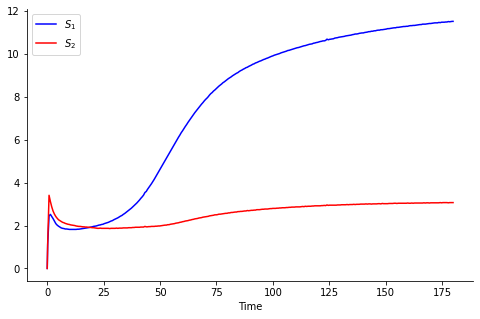

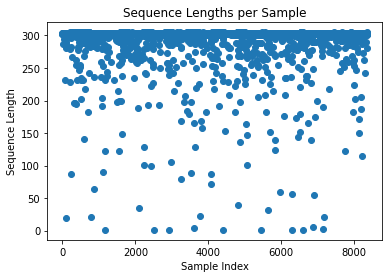

# low: 349
# high: 631
# normal: 6983
t5 min: 4.58
t5 max: 14.1
Class mapping: {'high': 0, 'low': 1, 'normal': 2}
Original training set distribution: {2: 5586, 1: 279, 0: 505}
Target count per class: 2123
Balanced training set distribution: {0: 2123, 1: 2123, 2: 2123}
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_8 (Masking)         (None, 305, 2)            0         
                                                                 
 lstm_16 (LSTM)              (None, 305, 32)           4480      
                                                                 
 dropout_16 (Dropout)        (None, 305, 32)           0         
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_17 (Dropout)        (None, 16)          

/home/mohammad/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mohammad/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mohammad/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


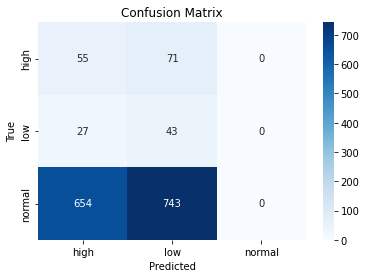

In [13]:
from bounds import bounds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import seaborn as sns

# --------------------------
# Data Loading & Preprocessing
# --------------------------
file_name = "DataOn2025Jan08.xlsx"
df1 = pd.read_excel(file_name, sheet_name="NES170K07Line2")

t5_lb = bounds["170K"][0]
t5_ub = bounds["170K"][1]
df2 = pd.read_excel(file_name, sheet_name="NES170K07Line1")

df = pd.concat([df1, df2], ignore_index=True)
print("Data shape:", df.shape)

def safe_literal_eval(value):
    """Handle NaN values before using ast.literal_eval"""
    if isinstance(value, str):
        value = value.replace("nan", "None")  # Replace 'nan' with None
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None  # Return None if it cannot be evaluated

def organized_data(df, t5_lb, t5_ub):
    data = {}
    for index, row in df.iterrows():
        if pd.isna(row['t5']):  # Skip if t5 is NaN
            continue

        batch_number = row["batch_number"]
        data[batch_number] = {
            "MDR": None,
            "t5": row["t5"],
            "class": None
        }
        
        t_S1 = safe_literal_eval(row["MDRTorqueS1"])
        t_S2 = safe_literal_eval(row["MDRTorqueS2"])

        if t_S1 is not None and t_S2 is not None:
            t_vals, S1 = zip(*t_S1)
            _, S2 = zip(*t_S2)
            t_vals, S1, S2 = list(t_vals), list(S1), list(S2)
            MDR = pd.DataFrame({
                "time": t_vals,
                "S1": S1,
                "S2": S2
            })
            
            # Interpolate and fill missing values
            MDR.interpolate(method="linear", inplace=True, limit_direction="both")
            MDR.fillna(method="bfill", inplace=True)
            MDR.fillna(method="ffill", inplace=True)
        else:
            continue  # Skip if no valid MDR data
        
        data[batch_number]["MDR"] = MDR

        # Assign class based on t5 thresholds
        if row["t5"] < t5_lb:
            data[batch_number]["class"] = "low"
        elif row["t5"] > t5_ub:
            data[batch_number]["class"] = "high"
        else:
            data[batch_number]["class"] = "normal"
    
    # Remove entries without valid MDR data
    data = {k: v for k, v in data.items() if v["MDR"] is not None and not v["MDR"].empty}
    return data

data = organized_data(df, t5_lb, t5_ub)

def iPlotCooperStandard(data, ID):
    t = data[ID]["MDR"]["time"]
    S1 = data[ID]["MDR"]["S1"]
    S2 = data[ID]["MDR"]["S2"]

    plt.figure(figsize=(8, 5))
    plt.plot(t, S1, color='blue', label=r'$S_1$')
    plt.plot(t, S2, color='red', label=r'$S_2$')
    plt.xlabel('Time')
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

# Plot an example batch (adjust ID as needed)
ID = 4104895
iPlotCooperStandard(data, ID)

# Examine sequence lengths and filter by a minimum length
lens = [v["MDR"].shape[0] for v in data.values()]
max_len = max(lens)
plt.scatter(np.arange(len(lens)), lens)
plt.xlabel("Sample Index")
plt.ylabel("Sequence Length")
plt.title("Sequence Lengths per Sample")
plt.show()

def len_condition(data, len_threshold):
    data = {k: v for k, v in data.items() if v["MDR"].shape[0] >= len_threshold}
    return data

data = len_condition(data, 290)

# Print number of samples per class
print(f'# low: {len({k: v for k, v in data.items() if v["class"]=="low"})}')
print(f'# high: {len({k: v for k, v in data.items() if v["class"]=="high"})}')
print(f'# normal: {len({k: v for k, v in data.items() if v["class"]=="normal"})}')

t5_list = [v['t5'] for v in data.values()]
print("t5 min:", min(t5_list))
print("t5 max:", max(t5_list))

# --------------------------
# Prepare Sequences for Classification
# --------------------------
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prepare_sequences(data_dict, max_len=max_len):
    """
    Process data dictionary into padded sequences and targets.
    Returns:
        X: Padded and normalized sequences (n_samples, max_len, num_features)
        y: Array of class labels (as strings)
        scalers: List of fitted StandardScalers for each feature
    """
    sequences = []
    targets = []
    
    for id in data_dict:
        df = data_dict[id]["MDR"]
        # Use features S1 and S2
        seq = df[['S1', 'S2']].values
        sequences.append(seq.astype('float32'))
        targets.append(data_dict[id]["class"])
    
    padded_sequences = pad_sequences(
        sequences,
        maxlen=max_len,
        dtype='float32',
        padding='post',
        truncating='post'
    )
    
    # Normalize features (feature-wise normalization)
    scalers = []
    normalized = []
    for feature_idx in range(padded_sequences.shape[2]):
        feature_data = padded_sequences[:, :, feature_idx].reshape(-1, 1)
        scaler = StandardScaler().fit(feature_data)
        scalers.append(scaler)
        normalized_feature = scaler.transform(feature_data).reshape(
            padded_sequences.shape[0], padded_sequences.shape[1], 1)
        normalized.append(normalized_feature)
    
    X = np.concatenate(normalized, axis=2)
    y = np.array(targets)
    return X, y, scalers

X, y, scalers = prepare_sequences(data)

# Encode class labels into integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Class mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

# Split the dataset (using stratification to preserve class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --------------------------
# Balance the Training Set
# --------------------------
# Perform undersampling from the majority ("normal") and oversampling from minority classes ("low" and "high")
from collections import Counter

unique_classes = np.unique(y_train)
class_indices = {}
for cls in unique_classes:
    class_indices[cls] = np.where(y_train == cls)[0]

# Compute the target count per class as the mean count
counts = [len(class_indices[cls]) for cls in unique_classes]
target_count = int(np.mean(counts))
print("Original training set distribution:", dict(Counter(y_train)))
print("Target count per class:", target_count)

new_indices = []
for cls in unique_classes:
    idx = class_indices[cls]
    if len(idx) > target_count:
        # Undersample: randomly choose target_count samples without replacement
        new_idx = np.random.choice(idx, target_count, replace=False)
    elif len(idx) < target_count:
        # Oversample: randomly choose samples with replacement to reach target_count
        new_idx = np.random.choice(idx, target_count, replace=True)
    else:
        new_idx = idx
    new_indices.extend(new_idx)

X_train_balanced = X_train[new_indices]
y_train_balanced = y_train[new_indices]
print("Balanced training set distribution:", dict(Counter(y_train_balanced)))

# --------------------------
# Build & Train a Classification LSTM Model
# --------------------------
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        LSTM(32, return_sequences=True),
        Dropout(0.3),
        LSTM(16),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

num_classes = len(encoder.classes_)
model = create_lstm_model((X_train_balanced.shape[1], X_train_balanced.shape[2]), num_classes)
model.summary()

history = model.fit(
    X_train_balanced, y_train_balanced,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

# Evaluate model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# --------------------------
# Compute F1 Score and Plot Confusion Matrix
# --------------------------
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate weighted F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: {:.4f}".format(f1))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
